Current Technical Indicators:
Close Price: $274.61
SMA 8: $277.21
SMA 20: $276.74
RSI: 50.18
MACD: 2.32
Signal: 3.53
Histogram: -1.21

Gap Analysis:
Gap Ups (>0.5%): 28
Gap Downs (>0.5%): 13

Gap Up Events:
  2025-06-20: +0.84%
  2025-06-24: +0.54%
  2025-06-25: +0.57%
  2025-07-01: +0.73%
  2025-07-02: +0.52%
  2025-07-16: +0.57%
  2025-08-01: +1.59%
  2025-08-04: +1.05%
  2025-08-06: +1.34%
  2025-08-07: +2.64%
  2025-08-13: +0.62%
  2025-08-15: +0.52%
  2025-08-22: +0.56%
  2025-09-03: +3.26%
  2025-09-15: +1.25%
  2025-09-19: +1.41%
  2025-09-22: +1.14%
  2025-10-13: +1.68%
  2025-10-15: +0.69%
  2025-10-20: +1.43%
  2025-10-23: +0.58%
  2025-10-24: +0.62%
  2025-10-27: +0.78%
  2025-10-30: +0.85%
  2025-10-31: +2.06%
  2025-11-18: +0.95%
  2025-11-20: +0.85%
  2025-12-15: +0.67%

Signal Interpretation:
  • SMA: Bearish (price below both SMAs)
  • SMA: Golden Cross (SMA8 > SMA20)
  • RSI: Neutral (50.2)
  • MACD: Bearish (below signal)


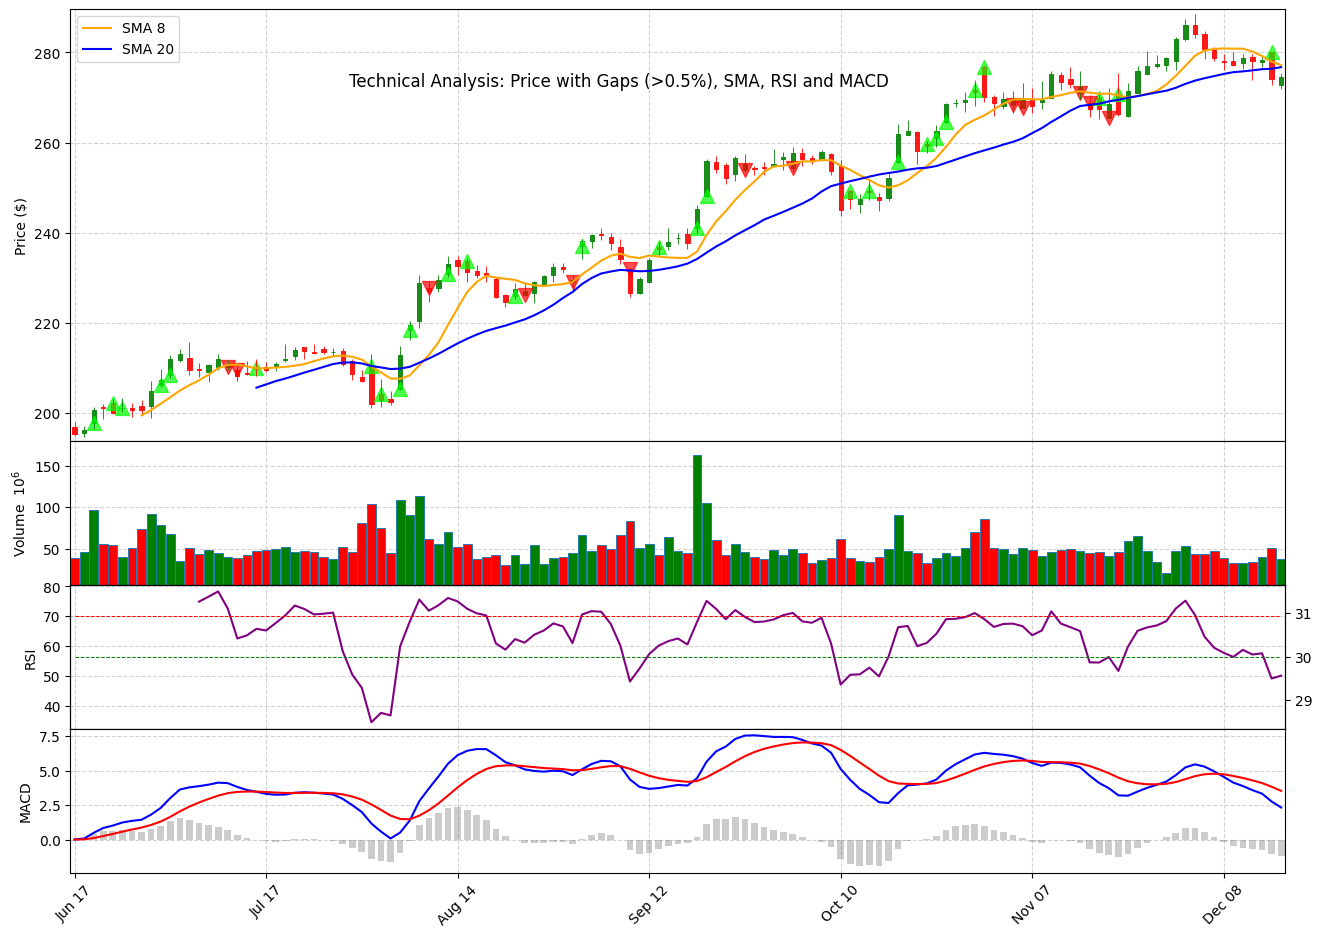


Legend:
  🔺 Green Triangle: Gap Up (>0.5%)
  🔻 Red Triangle: Gap Down (>0.5%)

How to use with real data:

# Using yfinance (install: pip install yfinance)
import yfinance as yf

ticker = yf.Ticker("AAPL")
df = ticker.history(period="6mo")

# Calculate indicators
df['RSI'] = calculate_rsi(df['Close'], period=14)
df['MACD'], df['Signal'], df['Histogram'] = calculate_macd(df['Close'])
df['SMA_8'] = calculate_sma(df['Close'], period=8)
df['SMA_20'] = calculate_sma(df['Close'], period=20)

# Identify gaps
gap_up_markers, gap_down_markers, gap_pct = identify_gaps(df, gap_threshold=0.5)

# Plot
apds = [
    mpf.make_addplot(df['SMA_8'], panel=0, color='orange', width=1.5),
    mpf.make_addplot(df['SMA_20'], panel=0, color='blue', width=1.5),
    mpf.make_addplot(gap_up_markers, panel=0, type='scatter', markersize=100, 
                     marker='^', color='lime', alpha=0.7),
    mpf.make_addplot(gap_down_markers, panel=0, type='scatter', markersize=100, 
                     marker='v', c

In [11]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import yfinance as yf

def calculate_rsi(data, period=14):
    """
    Calculate the Relative Strength Index (RSI) for a given dataset.
    
    Parameters:
    - data: pandas Series or DataFrame column with price data
    - period: lookback period for RSI calculation (default: 14)
    
    Returns:
    - pandas Series with RSI values
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.ewm(com=period-1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period-1, min_periods=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi


def calculate_macd(data, fast=12, slow=26, signal=9):
    """
    Calculate MACD (Moving Average Convergence Divergence) indicator.
    
    Parameters:
    - data: pandas Series or DataFrame column with price data
    - fast: fast EMA period (default: 12)
    - slow: slow EMA period (default: 26)
    - signal: signal line EMA period (default: 9)
    
    Returns:
    - tuple: (macd_line, signal_line, histogram)
    """
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram


def calculate_sma(data, period):
    """
    Calculate Simple Moving Average (SMA).
    
    Parameters:
    - data: pandas Series or DataFrame column with price data
    - period: lookback period for SMA calculation
    
    Returns:
    - pandas Series with SMA values
    """
    return data.rolling(window=period).mean()


def identify_gaps(df, gap_threshold=0.5):
    """
    Identify gap ups and gap downs.
    
    Parameters:
    - df: DataFrame with OHLC data
    - gap_threshold: minimum gap percentage to identify (default: 0.5%)
    
    Returns:
    - tuple: (gap_up_series, gap_down_series) for plotting
    """
    # Calculate gap percentage
    gap_pct = ((df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
    
    # Identify gap ups (gap > threshold)
    gap_ups = gap_pct[gap_pct > gap_threshold]
    
    # Identify gap downs (gap < -threshold)
    gap_downs = gap_pct[gap_pct < -gap_threshold]
    
    # Create series for plotting (use Open price for marker position)
    gap_up_markers = pd.Series(index=df.index, dtype=float)
    gap_up_markers.loc[gap_ups.index] = df.loc[gap_ups.index, 'Open']
    
    gap_down_markers = pd.Series(index=df.index, dtype=float)
    gap_down_markers.loc[gap_downs.index] = df.loc[gap_downs.index, 'Open']
    
    return gap_up_markers, gap_down_markers, gap_pct


# Generate sample OHLC data for demonstration
# np.random.seed(42)
# dates = pd.date_range('2024-01-01', periods=100, freq='D')

# # Create realistic OHLC data with some gap ups
# close_prices = 100 + np.cumsum(np.random.randn(100) * 2)

# # Add some gap ups (simulate news-driven price jumps)
# gap_days = [15, 35, 60, 78]  # Days where gaps occur
# for gap_day in gap_days:
#     if gap_day < len(close_prices):
#         close_prices[gap_day:] += np.random.uniform(1.5, 4.0)  # Create gap

# high_prices = close_prices + np.abs(np.random.randn(100) * 1.5)
# low_prices = close_prices - np.abs(np.random.randn(100) * 1.5)
# open_prices = close_prices + np.random.randn(100) * 1

# df = pd.DataFrame({
#     'Open': open_prices,
#     'High': high_prices,
#     'Low': low_prices,
#     'Close': close_prices,
#     'Volume': np.random.randint(1000000, 5000000, 100)
# }, index=dates)

ticker = yf.Ticker("AAPL")
df = ticker.history(period="6mo")

# Calculate indicators
df['RSI'] = calculate_rsi(df['Close'], period=14)
df['MACD'], df['Signal'], df['Histogram'] = calculate_macd(df['Close'])
df['SMA_8'] = calculate_sma(df['Close'], period=8)
df['SMA_20'] = calculate_sma(df['Close'], period=20)

# Identify gaps
gap_up_markers, gap_down_markers, gap_pct = identify_gaps(df, gap_threshold=0.5)

# Count gaps
num_gap_ups = gap_up_markers.notna().sum()
num_gap_downs = gap_down_markers.notna().sum()

# Display current values
print("Current Technical Indicators:")
print(f"Close Price: ${df['Close'].iloc[-1]:.2f}")
print(f"SMA 8: ${df['SMA_8'].iloc[-1]:.2f}")
print(f"SMA 20: ${df['SMA_20'].iloc[-1]:.2f}")
print(f"RSI: {df['RSI'].iloc[-1]:.2f}")
print(f"MACD: {df['MACD'].iloc[-1]:.2f}")
print(f"Signal: {df['Signal'].iloc[-1]:.2f}")
print(f"Histogram: {df['Histogram'].iloc[-1]:.2f}")
print(f"\nGap Analysis:")
print(f"Gap Ups (>0.5%): {num_gap_ups}")
print(f"Gap Downs (>0.5%): {num_gap_downs}\n")

# Show gap details
if num_gap_ups > 0:
    print("Gap Up Events:")
    gap_up_data = gap_pct[gap_pct > 0.5]
    for date, gap in gap_up_data.items():
        print(f"  {date.strftime('%Y-%m-%d')}: +{gap:.2f}%")
    print()

# Interpretation
def interpret_signals(row):
    signals = []
    
    # SMA interpretation
    if row['Close'] > row['SMA_8'] and row['Close'] > row['SMA_20']:
        signals.append("SMA: Bullish (price above both SMAs)")
    elif row['Close'] < row['SMA_8'] and row['Close'] < row['SMA_20']:
        signals.append("SMA: Bearish (price below both SMAs)")
    else:
        signals.append("SMA: Mixed signals")
    
    if row['SMA_8'] > row['SMA_20']:
        signals.append("SMA: Golden Cross (SMA8 > SMA20)")
    else:
        signals.append("SMA: Death Cross (SMA8 < SMA20)")
    
    # RSI interpretation
    if row['RSI'] >= 70:
        signals.append("RSI: Overbought (>70)")
    elif row['RSI'] <= 30:
        signals.append("RSI: Oversold (<30)")
    else:
        signals.append(f"RSI: Neutral ({row['RSI']:.1f})")
    
    # MACD interpretation
    if row['MACD'] > row['Signal']:
        signals.append("MACD: Bullish (above signal)")
    else:
        signals.append("MACD: Bearish (below signal)")
    
    return signals

current_signals = interpret_signals(df.iloc[-1])
print("Signal Interpretation:")
for signal in current_signals:
    print(f"  • {signal}")

# Create additional plots for SMA, RSI and MACD panels
apds = [
    # SMA lines on main panel (panel 0)
    mpf.make_addplot(df['SMA_8'], panel=0, color='orange', width=1.5, label='SMA 8'),
    mpf.make_addplot(df['SMA_20'], panel=0, color='blue', width=1.5, label='SMA 20'),
    
    # Gap up markers (green triangles pointing up)
    mpf.make_addplot(gap_up_markers, panel=0, type='scatter', markersize=100, 
                     marker='^', color='lime', alpha=0.7),
    
    # Gap down markers (red triangles pointing down)
    mpf.make_addplot(gap_down_markers, panel=0, type='scatter', markersize=100, 
                     marker='v', color='red', alpha=0.7),
    
    # RSI panel
    mpf.make_addplot(df['RSI'], panel=2, color='purple', width=1.5, ylabel='RSI'),
    mpf.make_addplot([70]*len(df), panel=2, color='red', linestyle='--', width=0.7),
    mpf.make_addplot([30]*len(df), panel=2, color='green', linestyle='--', width=0.7),
    
    # MACD panel
    mpf.make_addplot(df['MACD'], panel=3, color='blue', width=1.5, ylabel='MACD'),
    mpf.make_addplot(df['Signal'], panel=3, color='red', width=1.5),
    mpf.make_addplot(df['Histogram'], panel=3, type='bar', color='gray', alpha=0.4, width=0.7),
]

# Create the plot with custom style
mc = mpf.make_marketcolors(up='g', down='r', edge='inherit', wick='inherit', volume='in')
s = mpf.make_mpf_style(marketcolors=mc, gridstyle='--', gridcolor='lightgray')

# Plot with mplfinance
mpf.plot(df, 
         type='candle',
         style=s,
         title='Technical Analysis: Price with Gaps (>0.5%), SMA, RSI and MACD',
         ylabel='Price ($)',
         volume=True,
         addplot=apds,
         panel_ratios=(6,2,2,2),
         figsize=(14, 10),
         tight_layout=True)

print("\nLegend:")
print("  🔺 Green Triangle: Gap Up (>0.5%)")
print("  🔻 Red Triangle: Gap Down (>0.5%)")

print("\n" + "="*50)
print("How to use with real data:")
print("="*50)
print("""
# Using yfinance (install: pip install yfinance)
import yfinance as yf

ticker = yf.Ticker("AAPL")
df = ticker.history(period="6mo")

# Calculate indicators
df['RSI'] = calculate_rsi(df['Close'], period=14)
df['MACD'], df['Signal'], df['Histogram'] = calculate_macd(df['Close'])
df['SMA_8'] = calculate_sma(df['Close'], period=8)
df['SMA_20'] = calculate_sma(df['Close'], period=20)

# Identify gaps
gap_up_markers, gap_down_markers, gap_pct = identify_gaps(df, gap_threshold=0.5)

# Plot
apds = [
    mpf.make_addplot(df['SMA_8'], panel=0, color='orange', width=1.5),
    mpf.make_addplot(df['SMA_20'], panel=0, color='blue', width=1.5),
    mpf.make_addplot(gap_up_markers, panel=0, type='scatter', markersize=100, 
                     marker='^', color='lime', alpha=0.7),
    mpf.make_addplot(gap_down_markers, panel=0, type='scatter', markersize=100, 
                     marker='v', color='red', alpha=0.7),
    mpf.make_addplot(df['RSI'], panel=2, color='purple', width=1.5, ylabel='RSI'),
    mpf.make_addplot([70]*len(df), panel=2, color='red', linestyle='--', width=0.7),
    mpf.make_addplot([30]*len(df), panel=2, color='green', linestyle='--', width=0.7),
    mpf.make_addplot(df['MACD'], panel=3, color='blue', width=1.5, ylabel='MACD'),
    mpf.make_addplot(df['Signal'], panel=3, color='red', width=1.5),
    mpf.make_addplot(df['Histogram'], panel=3, type='bar', color='gray', alpha=0.4),
]

mpf.plot(df, type='candle', volume=True, addplot=apds, panel_ratios=(6,2,2,2))
""")